In [ ]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-16 06:19:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-16 06:19:00 (86.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-02-16 06:19:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   121MB/s    in 14s     

2023-02-16 06:19:19 (109 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_quesadilla'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/escargots'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pho'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/poutine'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/deviled_eggs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_c

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [ ]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [ ]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5


237/237 [==============================] - 148s 530ms/step - loss: 3.3762 - accuracy: 0.2700 - val_loss: 2.4865 - val_accuracy: 0.4592
Epoch 2/5
237/237 [==============================] - 102s 427ms/step - loss: 2.2081 - accuracy: 0.4894 - val_loss: 2.0828 - val_accuracy: 0.4952
Epoch 3/5
237/237 [==============================] - 92s 384ms/step - loss: 1.8247 - accuracy: 0.5642 - val_loss: 1.9115 - val_accuracy: 0.5220
Epoch 4/5
237/237 [==============================] - 93s 389ms/step - loss: 1.5963 - accuracy: 0.6157 - val_loss: 1.8418 - val_accuracy: 0.5305
Epoch 5/5
237/237 [==============================] - 87s 365ms/step - loss: 1.4426 - accuracy: 0.6470 - val_loss: 1.7797 - val_accuracy: 0.5381


In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10


237/237 [==============================] - 100s 372ms/step - loss: 1.2089 - accuracy: 0.6833 - val_loss: 1.7464 - val_accuracy: 0.5424
Epoch 6/10
237/237 [==============================] - 84s 351ms/step - loss: 1.0854 - accuracy: 0.7110 - val_loss: 1.7194 - val_accuracy: 0.5532
Epoch 7/10
237/237 [==============================] - 82s 344ms/step - loss: 1.0188 - accuracy: 0.7286 - val_loss: 1.7138 - val_accuracy: 0.5569
Epoch 8/10
237/237 [==============================] - 78s 328ms/step - loss: 0.9511 - accuracy: 0.7465 - val_loss: 1.6936 - val_accuracy: 0.5538
Epoch 9/10
237/237 [==============================] - 82s 342ms/step - loss: 0.8760 - accuracy: 0.7669 - val_loss: 1.7529 - val_accuracy: 0.5453
Epoch 10/10
237/237 [==============================] - 77s 323ms/step - loss: 0.8221 - accuracy: 0.7791 - val_loss: 1.7175 - val_accuracy: 0.5516


In [ ]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 63s 80ms/step - loss: 1.5013 - accuracy: 0.6032


[1.501320719718933, 0.6032475233078003]

In [ ]:
 tf.keras.models.save_model("drive/MyDrive/Colab Notebooks/101_food_classes_saved_model")

TypeError: ignored

In [ ]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

--2023-02-16 06:38:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.128, 142.250.152.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   123MB/s    in 0.4s    

2023-02-16 06:39:00 (123 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 65s 80ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027206659317017, 0.6077623963356018)

In [ ]:
loaded_model = tf.saved_model.load("drive/MyDrive/Colab Notebooks/101_food_classes_saved_model")

In [ ]:
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model


790/790 [==============================] - 63s 79ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

In [ ]:
preds_probs = model.predict(test_data,verbose=1)

790/790 [==============================] - 65s 81ms/step


In [ ]:
pred_classes = preds_probs.argmax(axis=1)

pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
y_labels=[]
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
 import numpy as np 
 np.isclose(results_downloaded_model[1],sklearn_accuracy)

True

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # rotating x-label in vertical direction 
  plt.xticks(rotation=70,fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


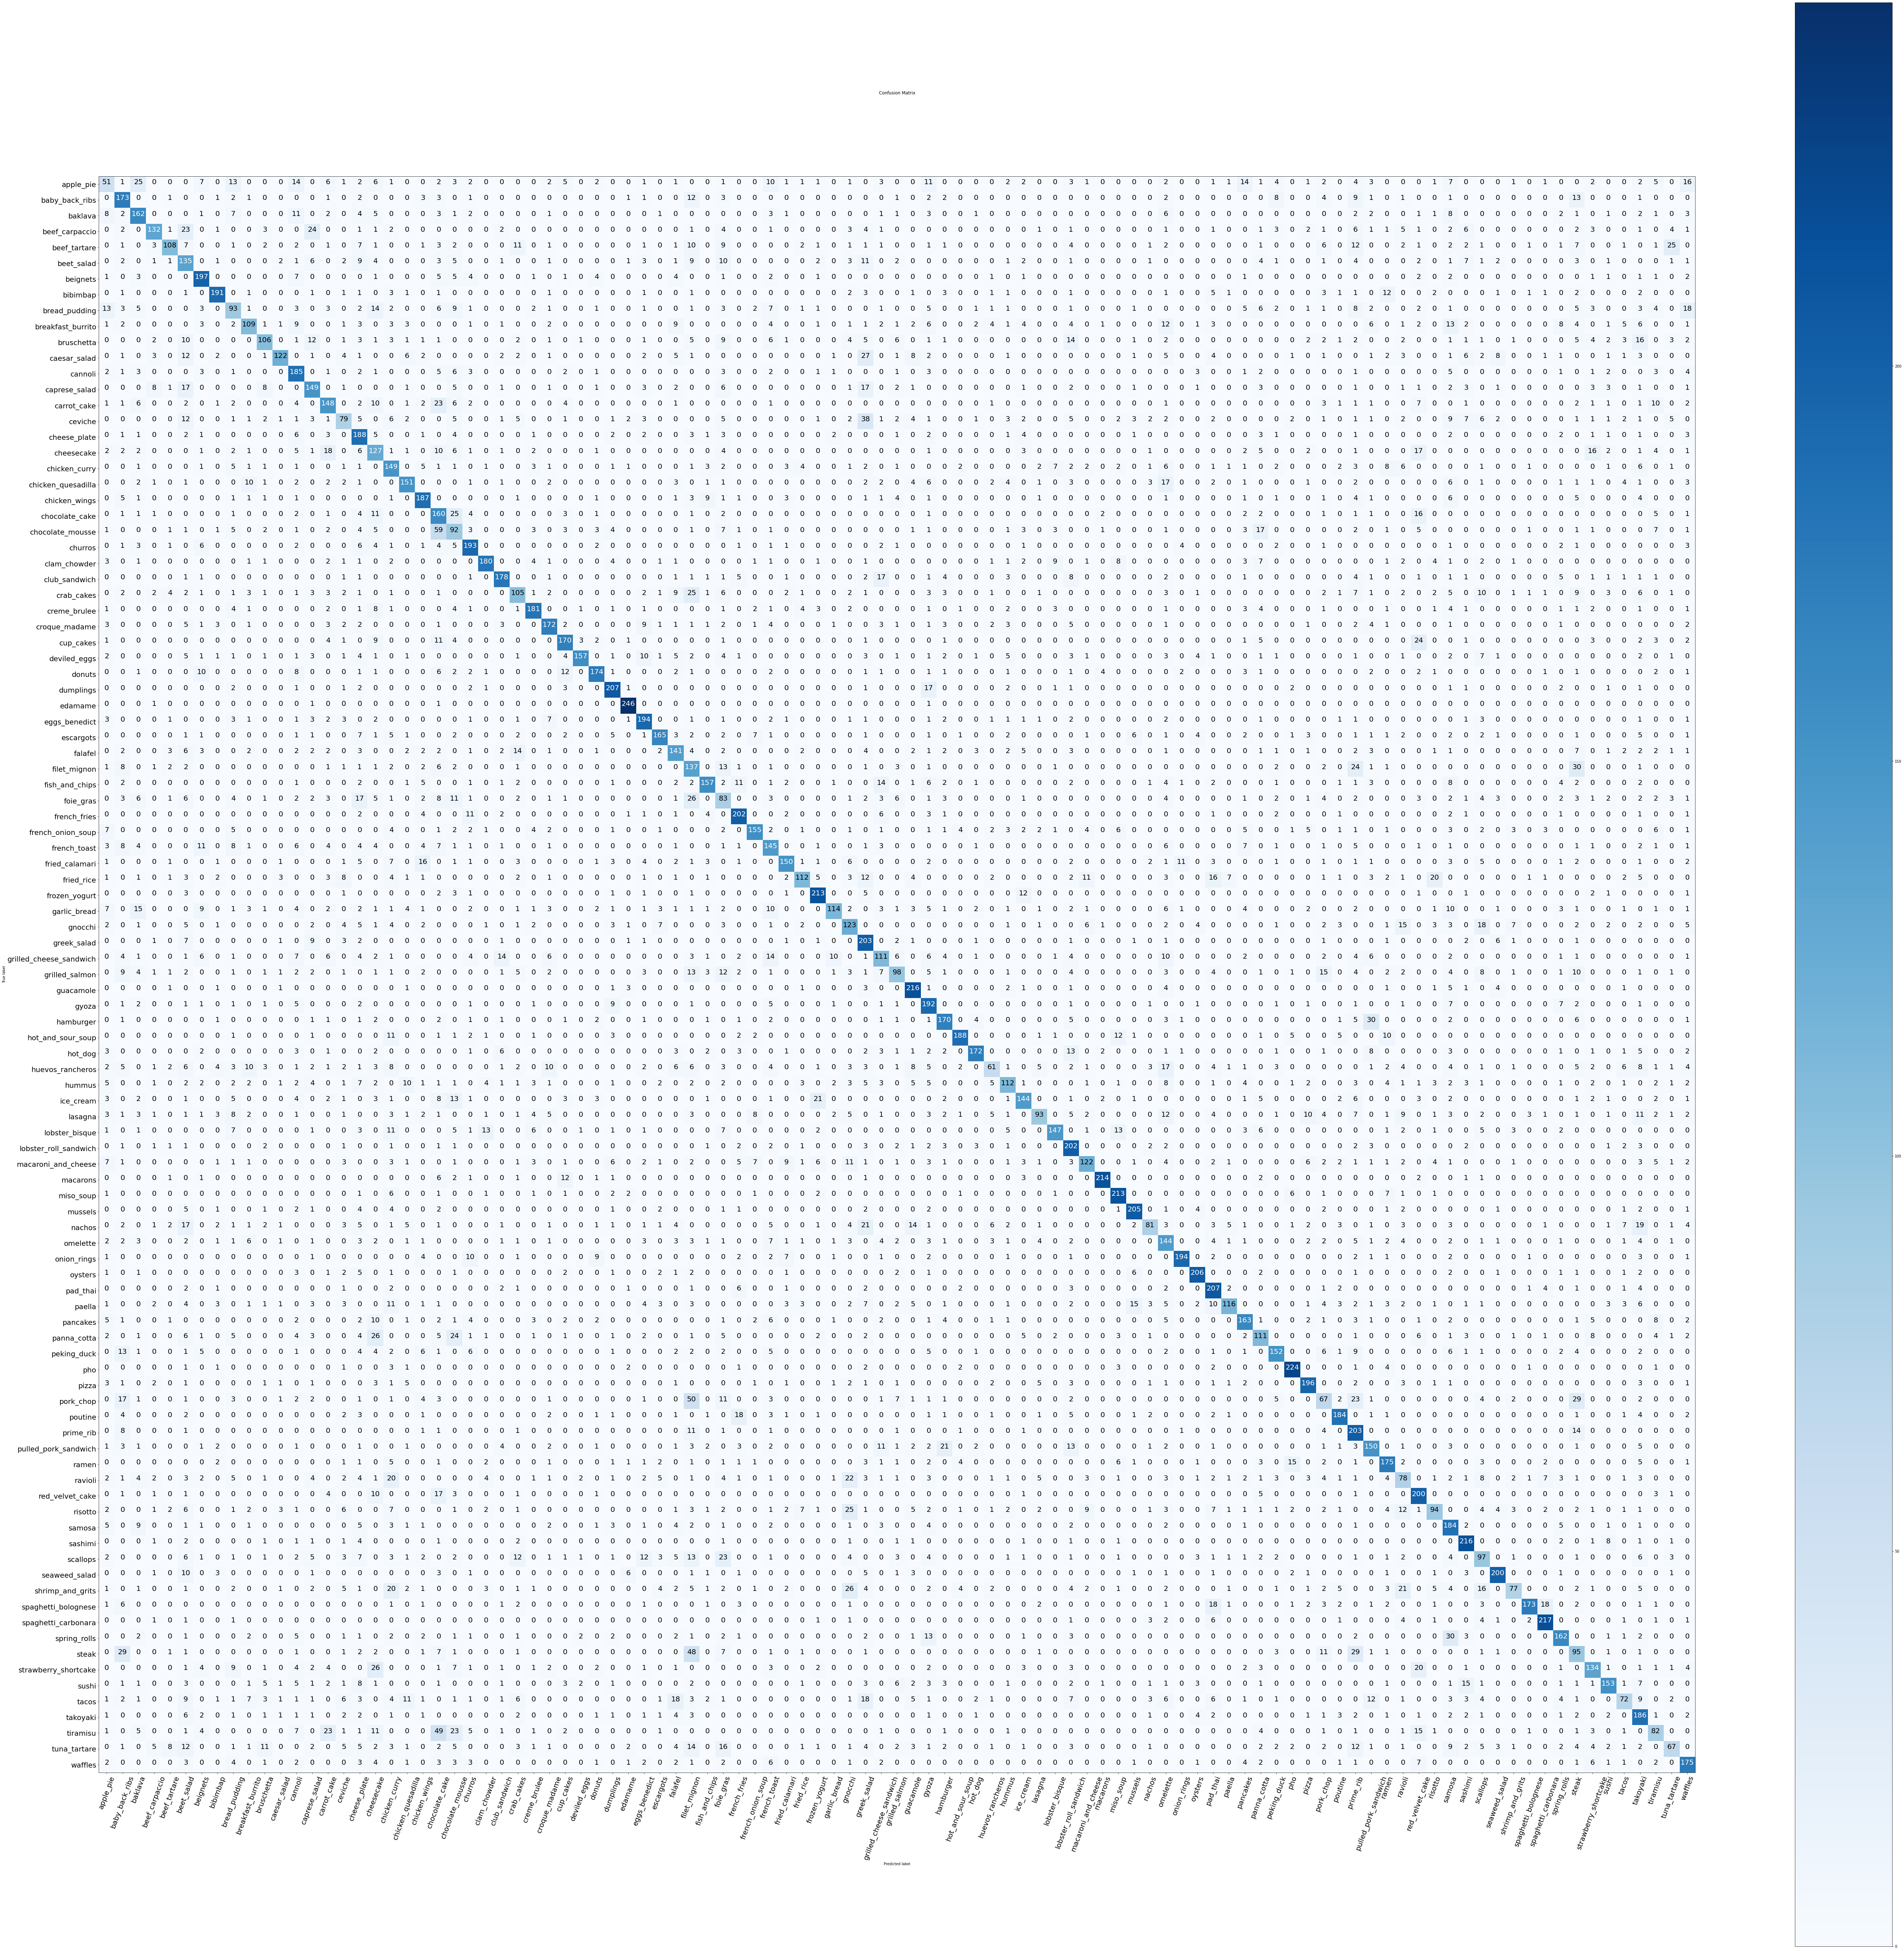

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
classification_report_dict = classification_report(y_labels,pred_classes,output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [ ]:
class_f1_scores = {}

for k,v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
import pandas as pd 
f1_score = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                         "f1-score":list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [ ]:
f1_score

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


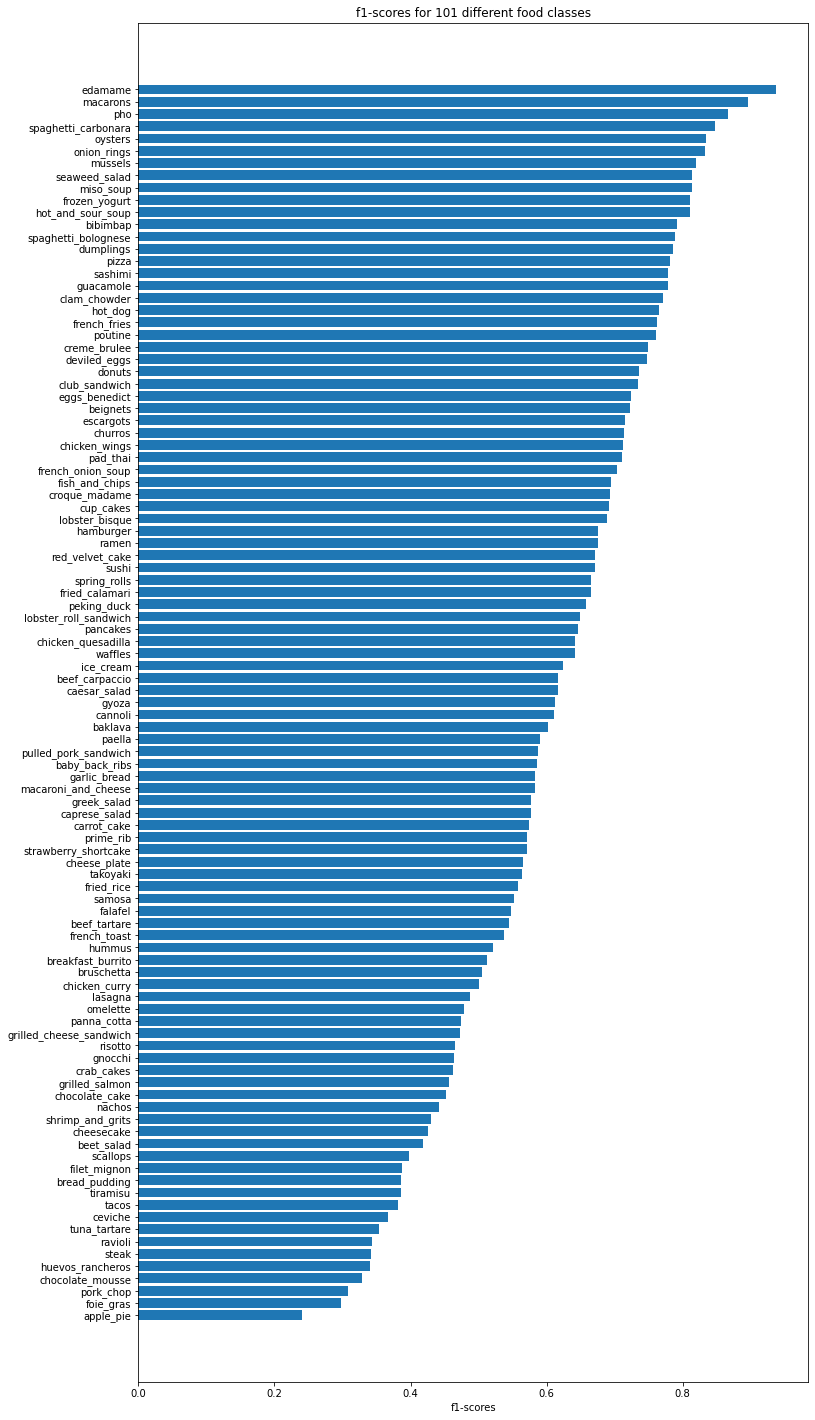

In [ ]:
import matplotlib.pyplot as plt 

fig,ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_score)),f1_score["f1-score"].values)
ax.set_yticks(range(len(f1_score)))
ax.set_yticklabels(f1_score["class_names"]);
ax.set_xlabel("f1-scores")
ax.set_title("f1-scores for 101 different food classes")
ax.invert_yaxis();

In [ ]:
def load_and_prep_image(filename,img_shape=224,scale=True):
  """
  Reads in an image from filename and then turns it into tensor and reshapes it to the specified 
  shape (img_shape,img_shape,color_channels=3).
  
  Args:
    filename(str):path to target.
    image_shape(int):height,width of target image.
    scale(bool):scale pixel values from 0-255 to 0-1 or not.
  """
  img = tf.io.read_file(filename)

  img = tf.io.decode_image(img,channels=3)

  img = tf.image.resize(img,[img_shape,img_shape])

  if scale:
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 32ms/step


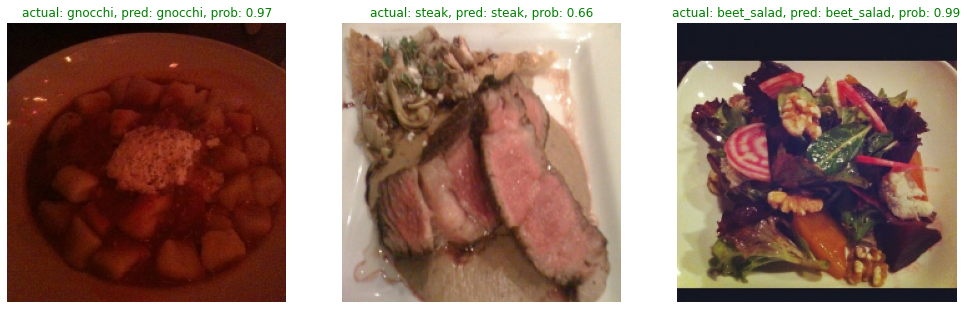

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [ ]:
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
import pandas as pd
pred_df = pd.DataFrame({"img_path":filepaths,
                         "y_true":y_labels,
                         "y_pred":pred_classes,
                         "pred_conf":preds_probs.max(axis=1),
                         "y_true_classname":[class_names[i] for i in y_labels],
                         "y_pred_classname":[class_names[i] for i in pred_classes]})
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367901,apple_pie,prime_rib
...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.972823,waffles,waffles
25246,b'/content/101_food_classes_10_percent/test/wa...,100,16,0.878028,waffles,cheese_plate
25247,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.537899,waffles,waffles
25248,b'/content/101_food_classes_10_percent/test/wa...,100,94,0.501949,waffles,strawberry_shortcake


In [ ]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza,False
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367901,apple_pie,prime_rib,False


In [ ]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf",ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
21810,b'/content/101_food_classes_10_percent/test/sc...,87,29,0.999997,scallops,cup_cakes,False
231,b'/content/101_food_classes_10_percent/test/ap...,0,100,0.999995,apple_pie,waffles,False
15359,b'/content/101_food_classes_10_percent/test/lo...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'/content/101_food_classes_10_percent/test/st...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'/content/101_food_classes_10_percent/test/sa...,85,92,0.999981,samosa,spring_rolls,False
24540,b'/content/101_food_classes_10_percent/test/ti...,98,83,0.999947,tiramisu,red_velvet_cake,False
2511,b'/content/101_food_classes_10_percent/test/br...,10,61,0.999945,bruschetta,lobster_roll_sandwich,False
5574,b'/content/101_food_classes_10_percent/test/ch...,22,21,0.999939,chocolate_mousse,chocolate_cake,False
17855,b'/content/101_food_classes_10_percent/test/pa...,71,65,0.999931,paella,mussels,False
23797,b'/content/101_food_classes_10_percent/test/su...,95,86,0.999904,sushi,sashimi,False


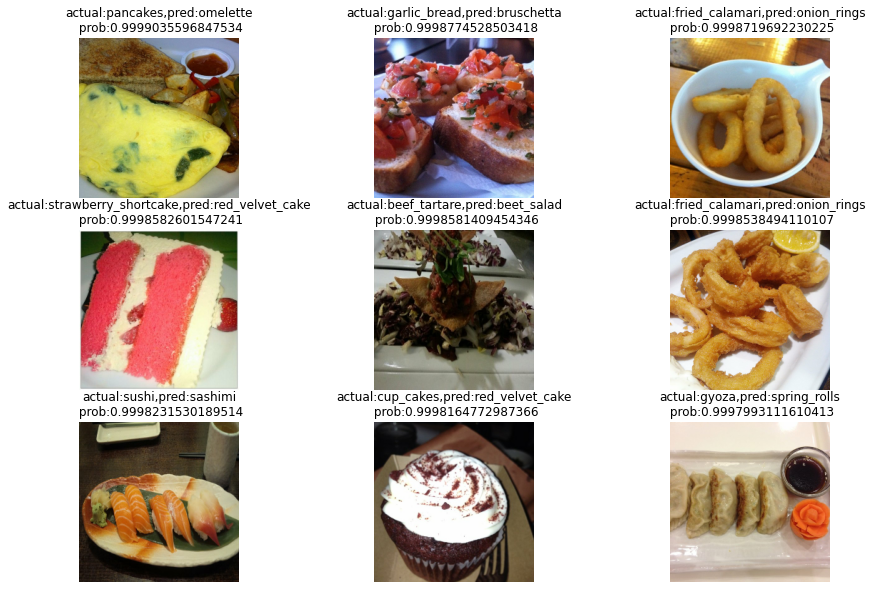

In [ ]:
images_to_view = 9
start_index = 10
plt.figure(figsize=(15,10))
for i,row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1],scale=False)
  _,_,_,_,pred_prob,y_true_classname,y_pred_class_name,_=row
  plt.imshow(img/255.)
  plt.title(f"actual:{y_true_classname},pred:{y_pred_class_name}\n prob:{pred_prob}")
  plt.axis(False)

In [ ]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")  

--2023-02-16 06:45:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  74.3MB/s    in 0.2s    

2023-02-16 06:45:25 (74.3 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
custom_food_images = ["custom_food_images "+ img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images chicken_wings.jpeg',
 'custom_food_images steak.jpeg',
 'custom_food_images ramen.jpeg',
 'custom_food_images sushi.jpeg',
 'custom_food_images pizza-dad.jpeg',
 'custom_food_images hamburger.jpeg']

In [ ]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

NotFoundError: ignored